In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
import time
from hashlib import sha256

defining curves

In [ ]:
# SECP256R1 (NIST P-256)
secp256r1 = {
    'p': 0xFFFFFFFF000000010000000000000000FFFFFFFFFFFFFFFFFFFFFFFF,
    'a': 0xFFFFFFFF000000010000000000000000FFFFFFFFFFFFFFFFFFFFFFFC,
    'b': 0x5AC635D8AA3A93E7B3EBBD55769886BC651D06B0CC53B0F63BCE3C3E27D2604B,
    'Gx': 0x6B17D1F2E12C4247F8BCE6E563A440F277037D812DEB33A0F4A13945D898C296,
    'Gy': 0x4FE342E2FE1A7F9B8EE7EB4A7C0F9E162BCE33576B315ECECBB6406837BF51F5,
    'n': 0xFFFFFFFF00000000FFFFFFFFFFFFFFFFBCE6FAADA7179E84F3B9CAC2FC632551
}

# Curve25519 (X25519)
curve25519 = {
    'p': 2**255 - 19,
    'a': 486662,
    'Gx': 9,
    'n': 2**252 + 0x14DEF9DEA2F79CD65812631A5CF5D3ED
}

# BrainpoolP256r1
brainpoolp256r1 = {
    'p': 0xA9FB57DBA1EEA9BC3E660A909D838D726E3BF623D52620282013481D1F6E5377,
    'a': 0x7D5A0975FC2C3057EEF67530417AFFE7FB8055C126DC5C6CE94A4B44F330B5D9,
    'b': 0x26DC5C6CE94A4B44F330B5D9BBD77CBF958416295CF7E1CE6BCCDC18FF8C07B6,
    'Gx': 0x8BD2AEB9CB7E57CB2C4B482FFC81B7AFB9DE27E1E3BD23C23A4453BD9ACE3262,
    'Gy': 0x547EF835C3DAC4FD97F8461A14611DC9C27745132DED8E545C1D54C72F046997,
    'n': 0xA9FB57DBA1EEA9BC3E660A909D838D718C397AA3B561A6F7901E0E82974856A7
}


Mathematical helper functions

In [ ]:
def mod_inv(a, p):
    """Find modular inverse using Fermat's Little Theorem"""
    return pow(a, p-2, p)

def is_on_curve(x, y, curve):
    """Check if a point is on the curve"""
    if curve == curve25519:
        return (y**2) % curve['p'] == (x**3 + curve['a']*x**2 + x) % curve['p']
    else:
        return (y**2 - x**3 - curve['a']*x - curve['b']) % curve['p'] == 0

point addition for weirstrass curve

In [ ]:
def point_add(P, Q, curve):
    if P is None: return Q
    if Q is None: return P

    x1, y1 = P
    x2, y2 = Q

    if x1 == x2:
        if y1 != y2: return None  # Point at infinity
        # Explicit negative handling for 'a'
        m_numerator = 3*x1*x1 + curve['a']
    else:
        m_numerator = y2 - y1

    m_denominator = x2 - x1 if x1 != x2 else 2*y1
    m = (m_numerator * mod_inv(m_denominator, curve['p'])) % curve['p']

    x3 = (m*m - x1 - x2) % curve['p']
    y3 = (m*(x1 - x3) - y1) % curve['p']

    return (x3, y3)

scalar multiplication for weirstrass curve

In [ ]:
def scalar_mult(k, point, curve):
    """Multiply point by scalar k using double-and-add"""
    result = None
    current = point

    while k > 0:
        if k % 2 == 1:
            result = point_add(result, current, curve)
        current = point_add(current, current, curve)
        k = k // 2

    return result

for Montegomery Curves

In [ ]:
def x25519_scalar_mult(k, u):
    """Montgomery ladder for Curve25519"""
    p = curve25519['p']
    a24 = 121665  # (a + 2)/4

    x1 = u
    x2 = 1
    z2 = 0
    x3 = u
    z3 = 1

    for t in reversed(range(255)):
        kt = (k >> t) & 1
        x2, x3 = (x3, x2) if kt else (x2, x3)
        z2, z3 = (z3, z2) if kt else (z2, z3)

        A = (x2 + z2) % p
        AA = (A * A) % p
        B = (x2 - z2) % p
        BB = (B * B) % p
        E = (AA - BB) % p
        C = (x3 + z3) % p
        D = (x3 - z3) % p
        DA = (D * A) % p
        CB = (C * B) % p
        x3 = ((DA + CB) ** 2) % p
        z3 = (x1 * (DA - CB) ** 2) % p
        x2 = (AA * BB) % p
        z2 = (E * (AA + a24 * E)) % p

        x2, x3 = (x3, x2) if kt else (x2, x3)
        z2, z3 = (z3, z2) if kt else (z2, z3)

    return (x2 * pow(z2, p-2, p)) % p

key generation

In [ ]:
def generate_keypair(curve_type):
    """Generate private/public key pair for selected curve"""
    if curve_type == 'secp256r1':
        curve = secp256r1
        priv = random.randint(1, curve['n']-1)
        pub = scalar_mult(priv, (curve['Gx'], curve['Gy']), curve)
    elif curve_type == 'brainpoolp256r1':
        curve = brainpoolp256r1
        priv = random.randint(1, curve['n']-1)
        pub = scalar_mult(priv, (curve['Gx'], curve['Gy']), curve)
    elif curve_type == 'curve25519':
        curve = curve25519
        priv = random.getrandbits(256) % curve['n']
        pub = x25519_scalar_mult(priv, curve['Gx'])
    else:
        raise ValueError("Unknown curve type")

    return priv, pub

ecdh implementation

In [ ]:
def ecdh(priv_key, peer_pub, curve_type):
    """Compute shared secret using peer's public key"""
    if curve_type in ['secp256r1', 'brainpoolp256r1']:
        curve = secp256r1 if curve_type == 'secp256r1' else brainpoolp256r1
        shared_point = scalar_mult(priv_key, peer_pub, curve)
        return shared_point[0]  # Use x-coordinate
    elif curve_type == 'curve25519':
        return x25519_scalar_mult(priv_key, peer_pub)
    else:
        raise ValueError("Unsupported curve type")

Demo

In [ ]:
def derive_key(shared_secret):
    """Create symmetric key from shared secret"""
    return sha256(str(shared_secret).encode()).digest()

def simple_encrypt(message, key):
    """XOR-based encryption for demonstration"""
    return bytes([message[i] ^ key[i % len(key)] for i in range(len(message))])

def run_interactive_demo():
    print("🛡️ ECDH Encryption Demo")

    # Curve selection
    print("\nChoose your curve:")
    print("1. secp256r1 (NIST P-256)")
    print("2. Curve25519 (X25519)")
    print("3. BrainpoolP256r1")
    choice = input("Enter choice (1/2/3): ").strip()

    curve_type = {
        '1': 'secp256r1',
        '2': 'curve25519',
        '3': 'brainpoolp256r1'
    }.get(choice, 'secp256r1')

    # Key setup
    print(f"\n🔑 {curve_type} Key Setup")
    your_priv = int(input("Enter YOUR private key (hex): "), 16)
    their_priv = int(input("Enter THEIR private key (hex): "), 16)

    # Generate public keys
    if curve_type == 'curve25519':
        your_pub = x25519_scalar_mult(your_priv, curve25519['Gx'])
        their_pub = x25519_scalar_mult(their_priv, curve25519['Gx'])
    else:
        curve = secp256r1 if curve_type == 'secp256r1' else brainpoolp256r1
        your_pub = scalar_mult(your_priv, (curve['Gx'], curve['Gy']), curve)
        their_pub = scalar_mult(their_priv, (curve['Gx'], curve['Gy']), curve)

    # Calculate shared secret
    shared_secret = ecdh(your_priv, their_pub, curve_type)
    print(f"\n🔒 Shared secret: {hex(shared_secret)}")

    # Message encryption
    message = input("\n✉️ Enter message to encrypt: ").encode()
    key = derive_key(shared_secret)
    ciphertext = simple_encrypt(message, key)
    print(f"🔐 Encrypted: {ciphertext.hex()}")

    # Message decryption
    decrypted = simple_encrypt(ciphertext, key).decode()
    print(f"\n🔓 Decrypted message: {decrypted}")

scalar blinding

In [ ]:
# Scalar Blinding Add-on
def apply_scalar_blinding(k, curve_type):
    """Optional scalar blinding protection"""
    if curve_type == 'secp256r1':
        n = secp256r1['n']
    elif curve_type == 'curve25519':
        n = curve25519['n']
    elif curve_type == 'brainpoolp256r1':
        n = brainpoolp256r1['n']
    else:
        raise ValueError("Unknown curve type")

    r = random.randint(1, n-1)
    return (k + r * n) % n

In [ ]:
# Modified Key Generation with Blinding Option
def generate_keypair(curve_type, use_blinding=False):
    """Generate keys with optional blinding"""
    if curve_type == 'secp256r1':
        curve = secp256r1
        priv = random.randint(1, curve['n']-1)
        if use_blinding:
            priv = apply_scalar_blinding(priv, curve_type)
        pub = scalar_mult(priv, (curve['Gx'], curve['Gy']), curve)
    elif curve_type == 'brainpoolp256r1':
        curve = brainpoolp256r1
        priv = random.randint(1, curve['n']-1)
        if use_blinding:
            priv = apply_scalar_blinding(priv, curve_type)
        pub = scalar_mult(priv, (curve['Gx'], curve['Gy']), curve)
    elif curve_type == 'curve25519':
        curve = curve25519
        priv = random.getrandbits(256) % curve['n']
        if use_blinding:
            priv = apply_scalar_blinding(priv, curve_type)
        pub = x25519_scalar_mult(priv, curve['Gx'])
    else:
        raise ValueError("Unknown curve type")
    return priv, pub

In [ ]:
# Enhanced ECDH with Blinding Toggle
def ecdh(priv_key, peer_pub, curve_type, use_blinding=False):
    """Compute shared secret with optional blinding"""
    if use_blinding:
        priv_key = apply_scalar_blinding(priv_key, curve_type)

    if curve_type in ['secp256r1', 'brainpoolp256r1']:
        curve = secp256r1 if curve_type == 'secp256r1' else brainpoolp256r1
        shared_point = scalar_mult(priv_key, peer_pub, curve)
        return shared_point[0]  # x-coordinate
    elif curve_type == 'curve25519':
        return x25519_scalar_mult(priv_key, peer_pub)
    else:
        raise ValueError("Unsupported curve type")

In [ ]:
# Cell 12: Enhanced Interactive Demo with Full Flow
def derive_key(shared_secret):
    """Create 256-bit key from shared secret"""
    return sha256(str(shared_secret).encode()).digest()

def simple_encrypt(message, key):
    """XOR encryption for demonstration (not secure!)"""
    return bytes([message[i] ^ key[i % len(key)] for i in range(len(message))])

def run_full_demo():
    print("🔐 Full ECDH Encryption Demo")

    # Curve selection
    print("\nChoose curve:")
    print("1. secp256r1 (NIST P-256)")
    print("2. Curve25519 (X25519)")
    print("3. BrainpoolP256r1")
    curve_choice = input("Enter choice (1/2/3): ").strip()
    curve_type = {'1': 'secp256r1', '2': 'curve25519', '3': 'brainpoolp256r1'}.get(curve_choice, 'secp256r1')

    # Blinding choice
    use_blinding = 'y'

    # Key setup
    print(f"\n🔑 {curve_type} Key Setup")
    if input("Generate random keys? (y/n): ").lower() == 'y':
        alice_priv, alice_pub = generate_keypair(curve_type, use_blinding)
        bob_priv, bob_pub = generate_keypair(curve_type, use_blinding)
    else:
        alice_priv = int(input("Enter Alice's private key (hex): "), 16)
        bob_priv = int(input("Enter Bob's private key (hex): "), 16)

        # Generate public keys from provided private keys
        if curve_type == 'curve25519':
            alice_pub = x25519_scalar_mult(alice_priv, curve25519['Gx'])
            bob_pub = x25519_scalar_mult(bob_priv, curve25519['Gx'])
        else:
            curve = secp256r1 if curve_type == 'secp256r1' else brainpoolp256r1
            alice_pub = scalar_mult(alice_priv, (curve['Gx'], curve['Gy']), curve)
            bob_pub = scalar_mult(bob_priv, (curve['Gx'], curve['Gy']), curve)

    # Compute shared secrets
    alice_shared = ecdh(alice_priv, bob_pub, curve_type, use_blinding)
    bob_shared = ecdh(bob_priv, alice_pub, curve_type, use_blinding)

    print(f"\n🔒 Alice's shared secret: {hex(alice_shared)}")
    print(f"🔒 Bob's shared secret:   {hex(bob_shared)}")

    if alice_shared != bob_shared:
        print("❌ Error: Secrets don't match!")
        return

    # Message handling
    message = input("\n✉️ Enter secret message: ").encode()
    key = derive_key(alice_shared)

    # Encryption
    ciphertext = simple_encrypt(message, key)
    print(f"\n🔐 Encrypted message (hex): {ciphertext.hex()}")

    # Decryption
    decrypted = simple_encrypt(ciphertext, key)
    print(f"🔓 Decrypted message: {decrypted.decode()}")

    # Verification
    print("\n✅ Success!" if message == decrypted else "❌ Decryption failed!")

performance dashboard

In [ ]:
def benchmark_curve_operations(curve_type, use_blinding):
    """Time key generation, encryption, and decryption"""
    # Key generation
    start = time.time()
    priv, pub = generate_keypair(curve_type, use_blinding)
    keygen_time = time.time() - start

    # Generate peer keys
    peer_priv, peer_pub = generate_keypair(curve_type, use_blinding)

    # ECDH shared secret
    start = time.time()
    shared = ecdh(priv, peer_pub, curve_type, use_blinding)
    key = sha256(str(shared).encode()).digest()

    # Encryption
    message = b"Secret message for benchmarking"
    start = time.time()
    cipher = bytes([message[i] ^ key[i%32] for i in range(len(message))])
    encrypt_time = time.time() - start

    # Decryption
    start = time.time()
    plain = bytes([cipher[i] ^ key[i%32] for i in range(len(cipher))])
    decrypt_time = time.time() - start

    return (keygen_time, encrypt_time, decrypt_time)

# Cell 3: Run Benchmarks
curves = ['secp256r1', 'curve25519', 'brainpoolp256r1']
results = {
    'with_blinding': {curve: benchmark_curve_operations(curve, True) for curve in curves},
    'without_blinding': {curve: benchmark_curve_operations(curve, False) for curve in curves}
}

In [ ]:
def plot_metric(metric_idx, metric_name):
    x = np.arange(len(curves))
    width = 0.35

    with_blinding = [results['with_blinding'][curve][metric_idx] for curve in curves]
    without_blinding = [results['without_blinding'][curve][metric_idx] for curve in curves]

    fig, ax = plt.subplots(figsize=(8, 5))
    rects1 = ax.bar(x - width/2, without_blinding, width, label='Without Blinding', color='skyblue')
    rects2 = ax.bar(x + width/2, with_blinding, width, label='With Blinding', color='orange', hatch='//')

    ax.set_ylabel('Time (seconds)')
    ax.set_title(f'{metric_name} Time by Curve and Blinding')
    ax.set_xticks(x)
    ax.set_xticklabels(curves)
    ax.legend()
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Annotate bars
    for rect in rects1 + rects2:
        height = rect.get_height()
        ax.annotate(f'{height:.6f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)
    plt.tight_layout()
    plt.show()

MITM Attack

In [ ]:
def MITM_attack():
      class CurveParams:
          def __init__(self, name, p, a, b, Gx, Gy, n):
              self.name = name
              self.p = p
              self.a = a
              self.b = b
              self.G = (Gx, Gy)
              self.n = n

      # SECP256R1 (NIST P-256) parameters
      secp256r1 = CurveParams(
          name="secp256r1",
          p=0xFFFFFFFF000000010000000000000000FFFFFFFFFFFFFFFFFFFFFFFF,
          a=0xFFFFFFFF000000010000000000000000FFFFFFFFFFFFFFFFFFFFFFFC,
          b=0x5AC635D8AA3A93E7B3EBBD55769886BC651D06B0CC53B0F63BCE3C3E27D2604B,
          Gx=0x6B17D1F2E12C4247F8BCE6E563A440F277037D812DEB33A0F4A13945D898C296,
          Gy=0x4FE342E2FE1A7F9B8EE7EB4A7C0F9E162BCE33576B315ECECBB6406837BF51F5,
          n=0xFFFFFFFF00000000FFFFFFFFFFFFFFFFBCE6FAADA7179E84F3B9CAC2FC632551
      )

      def mod_inv(a, p):
          """Modular inverse using Extended Euclidean Algorithm"""
          old_r, r = a % p, p
          old_s, s = 1, 0
          while r != 0:
              quotient = old_r // r
              old_r, r = r, old_r - quotient * r
              old_s, s = s, old_s - quotient * s
          return old_s % p

      def point_add(P, Q, curve):
          """Weierstrass point addition with validation"""
          if P is None: return Q
          if Q is None: return P

          x1, y1 = P
          x2, y2 = Q

          if x1 == x2:
              if y1 != y2: return None  # Point at infinity
              # Point doubling
              m = (3 * pow(x1, 2, curve.p) + curve.a) * mod_inv(2 * y1, curve.p) % curve.p
          else:
              # Point addition
              m = (y2 - y1) * mod_inv(x2 - x1, curve.p) % curve.p

          x3 = (pow(m, 2, curve.p) - x1 - x2) % curve.p
          y3 = (m * (x1 - x3) - y1) % curve.p
          return (x3, y3)

      def scalar_mult(k, point, curve):
          """Constant-time scalar multiplication using double-and-add"""
          result = None
          current = point
          for bit in reversed(range(256)):  # Process all 256 bits
              if (k >> bit) & 1:
                  result = point_add(result, current, curve)
              current = point_add(current, current, curve)
          return result

      # --------------------------
      # 2. MITM Attack Implementation
      # --------------------------
      def mitm_attack_simulation():
          print("🔥 MITM Attack Simulation (Verified)")

          # Generate legitimate keys
          print("\n🔑 Legitimate Key Generation:")
          alice_priv = random.getrandbits(256) % secp256r1.n
          alice_pub = scalar_mult(alice_priv, secp256r1.G, secp256r1)

          bob_priv = random.getrandbits(256) % secp256r1.n
          bob_pub = scalar_mult(bob_priv, secp256r1.G, secp256r1)

          # Mallory's setup
          print("🔑 Mallory's Key Generation:")
          mallory_priv = random.getrandbits(256) % secp256r1.n
          mallory_pub = scalar_mult(mallory_priv, secp256r1.G, secp256r1)

          # Key substitution
          print("\n🕵️ MITM Key Replacement:")
          print(f"Original Alice Pub: {hex(alice_pub[0])[:20]}...")
          print(f"Original Bob Pub:   {hex(bob_pub[0])[:20]}...")

          # Mallory replaces both public keys with her own
          alice_receives = mallory_pub  # Sent to Alice as "Bob's key"
          bob_receives = mallory_pub    # Sent to Bob as "Alice's key"

          # Compute shared secrets
          print("\n🔒 Shared Secret Calculation:")
          alice_shared = scalar_mult(alice_priv, alice_receives, secp256r1)[0]
          bob_shared = scalar_mult(bob_priv, bob_receives, secp256r1)[0]

          mallory_alice_shared = scalar_mult(mallory_priv, alice_pub, secp256r1)[0]
          mallory_bob_shared = scalar_mult(mallory_priv, bob_pub, secp256r1)[0]

          print("\n💻 Attack Results:")
          print(f"Alice's Secret:   {hex(alice_shared)[:20]}...")
          print(f"Mallory's Secret: {hex(mallory_alice_shared)[:20]}...")
          print(f"Bob's Secret:     {hex(bob_shared)[:20]}...")
          print(f"Mallory's Secret: {hex(mallory_bob_shared)[:20]}...")

          # Verify attack success
          assert alice_shared == mallory_alice_shared, "MITM failed with Alice"
          assert bob_shared == mallory_bob_shared, "MITM failed with Bob"
          print("\n✅ MITM Attack Successful!")

          # Message interception demo
          def simple_encrypt(msg, key):
              return bytes([msg[i] ^ key[i%32] for i in range(len(msg))])

          print("\n📨 Message Interception Demo:")
          original_msg = b"Secret: Launch codes are 12345"
          key = sha256(str(alice_shared).encode()).digest()
          cipher = simple_encrypt(original_msg, key)

          # Mallory decrypts
          mallory_key = sha256(str(mallory_alice_shared).encode()).digest()
          decrypted = simple_encrypt(cipher, mallory_key)

          # Mallory modifies message
          modified_msg = b"Fake: Launch codes are 67890"
          mallory_cipher = simple_encrypt(modified_msg, sha256(str(mallory_bob_shared).encode()).digest())

          # Bob decrypts
          bob_decrypted = simple_encrypt(mallory_cipher, sha256(str(bob_shared).encode()).digest())

          print(f"Original Message:  {original_msg.decode()}")
          print(f"Mallory Decrypted: {decrypted.decode()}")
          print(f"Modified Message:  {modified_msg.decode()}")
          print(f"Bob Received:      {bob_decrypted.decode()}")

      # Run the simulation
      mitm_attack_simulation()

In [ ]:
MITM_attack()

🔥 MITM Attack Simulation (Verified)

🔑 Legitimate Key Generation:
🔑 Mallory's Key Generation:

🕵️ MITM Key Replacement:
Original Alice Pub: 0x549b55092fdf53789f...
Original Bob Pub:   0xa0ab1b66582987372e...

🔒 Shared Secret Calculation:

💻 Attack Results:
Alice's Secret:   0x734bbf88ede6124a9b...
Mallory's Secret: 0x734bbf88ede6124a9b...
Bob's Secret:     0x298125b5c8171cae60...
Mallory's Secret: 0x298125b5c8171cae60...

✅ MITM Attack Successful!

📨 Message Interception Demo:
Original Message:  Secret: Launch codes are 12345
Mallory Decrypted: Secret: Launch codes are 12345
Modified Message:  Fake: Launch codes are 67890
Bob Received:      Fake: Launch codes are 67890


#MAIN CODE



 _______  _______  ______   __   __    ___   _  _______  __   __    _______  __   __  _______  __   __  _______  __    _  _______  _______
|       ||       ||      | |  | |  |  |   | | ||       ||  | |  |  |       ||  |_|  ||       ||  | |  ||   _   ||  |  | ||       ||       |
|    ___||       ||  _    ||  |_|  |  |   |_| ||    ___||  |_|  |  |    ___||       ||       ||  |_|  ||  |_|  ||   |_| ||    ___||    ___|
|   |___ |       || | |   ||       |  |      _||   |___ |       |  |   |___ |       ||       ||       ||       ||       ||   | __ |   |___
|    ___||      _|| |_|   ||       |  |     |_ |    ___||_     _|  |    ___| |     | |      _||       ||       ||  _    ||   ||  ||    ___|
|   |___ |     |_ |       ||   _   |  |    _  ||   |___   |   |    |   |___ |   _   ||     |_ |   _   ||   _   || | |   ||   |_| ||   |___
|_______||_______||______| |__| |__|  |___| |_||_______|  |___|    |_______||__| |__||_______||__| |__||__| |__||_|  |__||_______||_______|


✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨

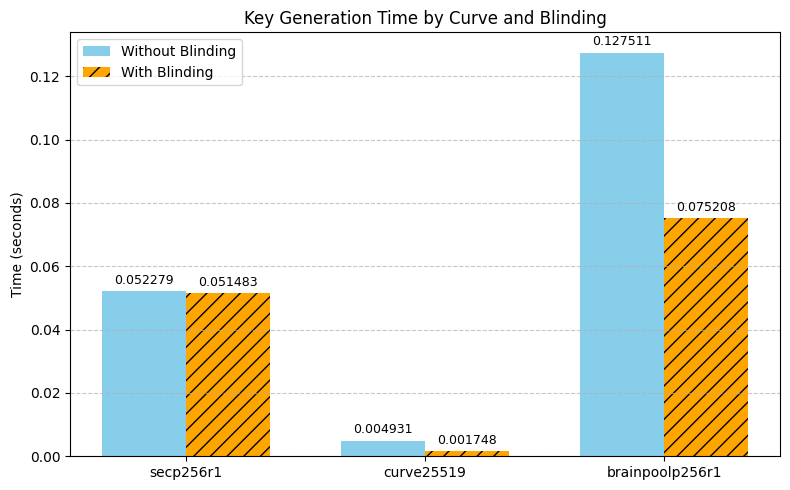

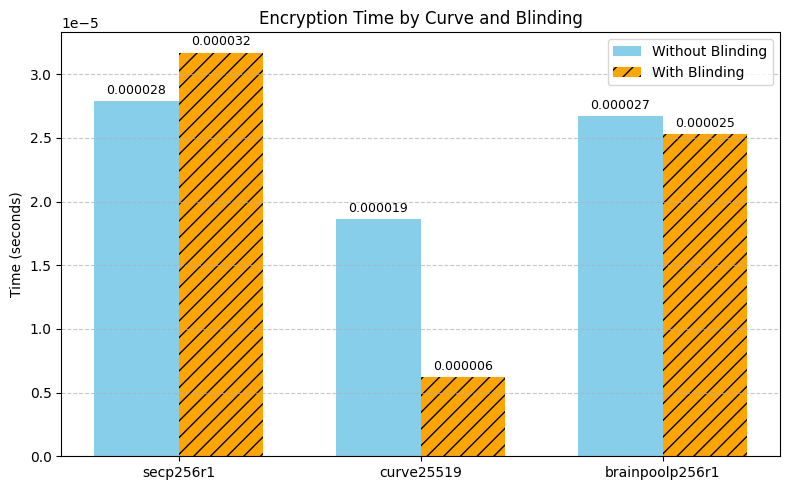

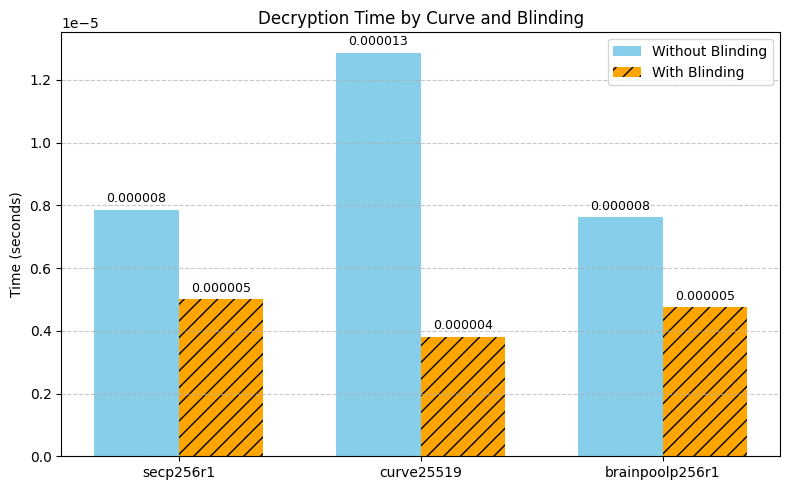

🔽 Press Enter to continue...


 _______  _______  ______   __   __    ___   _  _______  __   __    _______  __   __  _______  __   __  _______  __    _  _______  _______
|       ||       ||      | |  | |  |  |   | | ||       ||  | |  |  |       ||  |_|  ||       ||  | |  ||   _   ||  |  | ||       ||       |
|    ___||       ||  _    ||  |_|  |  |   |_| ||    ___||  |_|  |  |    ___||       ||       ||  |_|  ||  |_|  ||   |_| ||    ___||    ___|
|   |___ |       || | |   ||       |  |      _||   |___ |       |  |   |___ |       ||       ||       ||       ||       ||   | __ |   |___
|    ___||      _|| |_|   ||       |  |     |_ |    ___||_     _|  |    ___| |     | |      _||       ||       ||  _    ||   ||  ||    ___|
|   |___ |     |_ |       ||   _   |  |    _  ||   |___   |   |    |   |___ |   _   ||     |_ |   _   ||   _   || | |   ||   |_| ||   |___
|_______||_______||______| |__| |__|  |___| |_||_______|  |___|    |_______||__| |__||_______||__| |__||__| |__||_|  |__||_______||_

In [ ]:
import time

# Color Codes for terminals that support ANSI (Colab will ignore colors)
CYAN = "\033[1;36m"
PINK = "\033[1;35m"
GREEN = "\033[1;32m"
YELLOW = "\033[1;33m"
RED = "\033[1;31m"
RESET = "\033[0m"

ECDH_ASCII = f"""
{CYAN}
 _______  _______  ______   __   __    ___   _  _______  __   __    _______  __   __  _______  __   __  _______  __    _  _______  _______
|       ||       ||      | |  | |  |  |   | | ||       ||  | |  |  |       ||  |_|  ||       ||  | |  ||   _   ||  |  | ||       ||       |
|    ___||       ||  _    ||  |_|  |  |   |_| ||    ___||  |_|  |  |    ___||       ||       ||  |_|  ||  |_|  ||   |_| ||    ___||    ___|
|   |___ |       || | |   ||       |  |      _||   |___ |       |  |   |___ |       ||       ||       ||       ||       ||   | __ |   |___
|    ___||      _|| |_|   ||       |  |     |_ |    ___||_     _|  |    ___| |     | |      _||       ||       ||  _    ||   ||  ||    ___|
|   |___ |     |_ |       ||   _   |  |    _  ||   |___   |   |    |   |___ |   _   ||     |_ |   _   ||   _   || | |   ||   |_| ||   |___
|_______||_______||______| |__| |__|  |___| |_||_______|  |___|    |_______||__| |__||_______||__| |__||__| |__||_|  |__||_______||_______|
{RESET}
"""

WELCOME = f"{PINK}✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨{RESET}\n" \
          f"{YELLOW}👋 Welcome to the ECDH Playground! 👋{RESET}\n" \
          f"{PINK}✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨{RESET}\n"

FOOTER = f"\n{CYAN}───────────────────────────────────────────────{RESET}\n" \
         "       by Niharika and Sneha 💖\n" \
         f"{CYAN}───────────────────────────────────────────────{RESET}\n"

MENU = f"""
{CYAN}✨ What would you like to see today? ✨{RESET}

  1️⃣  {GREEN}🔐  ECDH Key Exchange with Scalar Blinding{RESET}
  2️⃣  {YELLOW}🔓  ECDH Key Exchange without Scalar Blinding{RESET}
  3️⃣  {PINK}📊  Performance Comparison Dashboard{RESET}
  4️⃣  {RED}🕵️  MITM Attack Simulation{RESET}
  5️⃣  {CYAN}🚪  Exit{RESET}
"""

def run_ecdh_with_blinding():
    print(f"\n{GREEN}🔐🔒✨ Running Secure ECDH with Scalar Blinding...{RESET}")
    # (Insert your ECDH with blinding code here)
    time.sleep(1)

def run_ecdh_without_blinding():
    print(f"\n{YELLOW}🔓🛡️  Running Standard ECDH without Blinding...{RESET}")
    # (Insert your ECDH without blinding code here)
    time.sleep(1)

def run_performance_dashboard():
    print(f"\n{PINK}📊⏱️🚀 Generating Performance Dashboard...{RESET}")
    # (Insert your performance dashboard code here)
    time.sleep(1)

def run_mitm_simulation():
    print(f"\n{RED}🕵️💻🔥 Launching MITM Attack Simulation...{RESET}")
    # (Insert your MITM attack simulation code here)
    time.sleep(1)

def main_menu():
    while True:
        print(ECDH_ASCII)
        print(WELCOME)
        print(MENU)
        choice = input("Please enter your choice (1-5): ").strip()
        if choice == "1":
            run_full_demo()
        elif choice == "2":
            run_interactive_demo()
        elif choice == "3":
            # Plot Key Generation Time
            plot_metric(0, "Key Generation")
            # Plot Encryption Time
            plot_metric(1, "Encryption")
            # Plot Decryption Time
            plot_metric(2, "Decryption")
        elif choice == "4":
            MITM_attack()
        elif choice == "5":
            print(f"\n{CYAN}🌈 Thanks for exploring ECDH! 👋 Goodbye!{RESET}\n")
            print(FOOTER)
            break
        else:
            print(f"{RED}❗ Invalid choice. Please try again.{RESET}\n")
        input(f"{CYAN}🔽 Press Enter to continue...{RESET}")

main_menu()
